# 1. Importing packages

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os

from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.xception import Xception

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/ofa-ai-mastery-computer-vision'

# 2. Visualising data

In [4]:
names = []
nums = []
data = {'Name of class':[],'Number of samples':[]}

for i in os.listdir(path+'/train'):
    nums.append(len(os.listdir(path+'/train/'+i)))
    names.append(i)

data['Name of class']+=names
data['Number of samples']+=nums

df = pd.DataFrame(data)
df

,Name of class,Number of samples
0,dog,900
1,cat,700
2,deer,600
3,horse,600


<Axes: xlabel='Name of class', ylabel='Number of samples'>

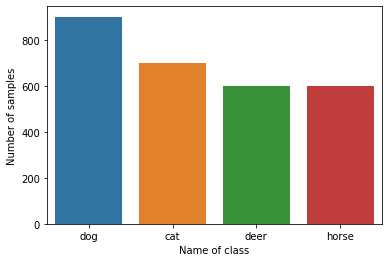

In [5]:
sns.barplot(x=df['Name of class'],y=df['Number of samples'])

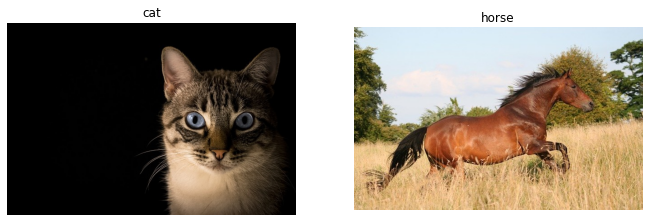

In [6]:
classes = os.listdir(path+'/train')

plt.figure(figsize=(30 , 30))
for x in range(2):
    i = random.randint(0,3)                    # getting the class
    images = os.listdir(path+'/train'+'/'+classes[i])
    j = random.randint(0,5)                  # getting the image
    image = cv2.imread(path+'/train'+'/'+classes[i]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(5, 5, x + 1)
    plt.imshow(image)
    plt.title(classes[i])
    plt.axis("off")

plt.show()

# 3. Preparing the data

In [7]:
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255 , rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True, validation_split=0.2)

In [8]:
train_ds = image_datagen.flow_from_directory(
        path+'/train',
        subset='training',
        target_size=(224 , 224),
        batch_size=16)

val_ds = image_datagen.flow_from_directory(
        path+'/train',
        subset='validation',
        target_size=(224 , 224),
        batch_size=16 )

Found 2240 images belonging to 4 classes.
Found 560 images belonging to 4 classes.


# 4. Building the model

In [14]:
# i'll be using inception_v3 for this model , along with 2 extra dense layers and the output layer

mymodel = tf.keras.applications.xception.Xception(input_shape=(224 , 224, 3),
                                           include_top=False,
                                           weights='imagenet')
# mymodel.trainable = False
model = Sequential()
model.add(mymodel)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation="softmax" , name="classification"))

In [15]:

checkpoint_filepath = '/content/drive/MyDrive/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)



In [16]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005,momentum=0.9), 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])



In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                      

# 5. Training and evaluating

In [18]:

# model.load_weights bisa di jalankan saat runtime google colabs ter restart

history = model.fit(train_ds , batch_size=15,  validation_data = val_ds , epochs = 30, callbacks=[model_checkpoint_callback])

Epoch 1/30
140/140 [==============================] - 94s 547ms/step - loss: 1.2893 - accuracy: 0.4500 - val_loss: 0.9798 - val_accuracy: 0.6393
Epoch 2/30
140/140 [==============================] - 63s 450ms/step - loss: 0.8987 - accuracy: 0.7549 - val_loss: 0.4880 - val_accuracy: 0.8804
Epoch 3/30
140/140 [==============================] - 73s 521ms/step - loss: 0.4613 - accuracy: 0.8759 - val_loss: 0.2718 - val_accuracy: 0.9304
Epoch 4/30
140/140 [==============================] - 63s 450ms/step - loss: 0.3107 - accuracy: 0.9004 - val_loss: 0.2000 - val_accuracy: 0.9357
Epoch 5/30
140/140 [==============================] - 63s 452ms/step - loss: 0.2511 - accuracy: 0.9183 - val_loss: 0.1826 - val_accuracy: 0.9393
Epoch 6/30
140/140 [==============================] - 63s 448ms/step - loss: 0.2033 - accuracy: 0.9286 - val_loss: 0.1566 - val_accuracy: 0.9500
Epoch 7/30
140/140 [==============================] - 63s 451ms/step - loss: 0.1739 - accuracy: 0.9406 - val_loss: 0.1257 - val_ac

In [19]:
model.load_weights(checkpoint_filepath)

35/35 [==============================] - 11s 322ms/step - loss: 0.1174 - accuracy: 0.9661


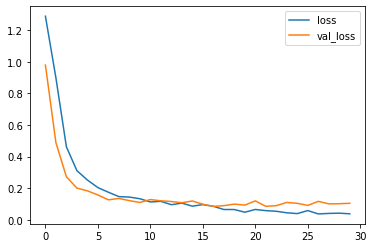

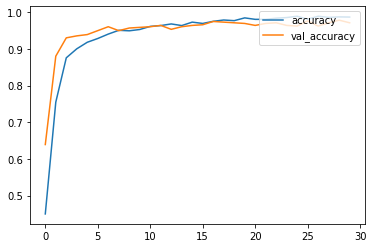

In [20]:
model.evaluate(val_ds)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

# 6. Preparing for submission

In [21]:
sub_csv ='/content/drive/MyDrive/ofa-ai-mastery-computer-vision/Sample_submission.csv'
path_test = '/content/drive/MyDrive/ofa-ai-mastery-computer-vision/test/test'

In [22]:
df_sub = pd.read_csv(sub_csv)
image_id = df_sub['ID']
df_sub.head(10)

,ID,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [23]:
# each image will be treated individually and saved in a list which is then merged with the id of it's correspondence

from tensorflow.keras.preprocessing.image import load_img


# making a list for our predictions
labels = []


for i in image_id:
    image = load_img(path_test+'/'+str(i)+'.jpg', target_size=(224, 224))
    img = np.array(image)
    img = img / 255.0
    img = img.reshape(1,224,224,3)
    label = model.predict(img)
    label_id = label[0].tolist()
    
    labels.append(label_id.index(max(label_id)))


1/1 [==============================] - 0s 27ms/step


In [24]:
# we will replace the previous empty columns with the new predictions    
    
df_sub['Label'] = labels
df_sub.head(10)

,ID,Label
0,1,1
1,2,0
2,3,2
3,4,3
4,5,2
5,6,1
6,7,3
7,8,0
8,9,3
9,10,2


In [26]:
# saving file
df_sub.to_csv('submission_file.csv',index=False)

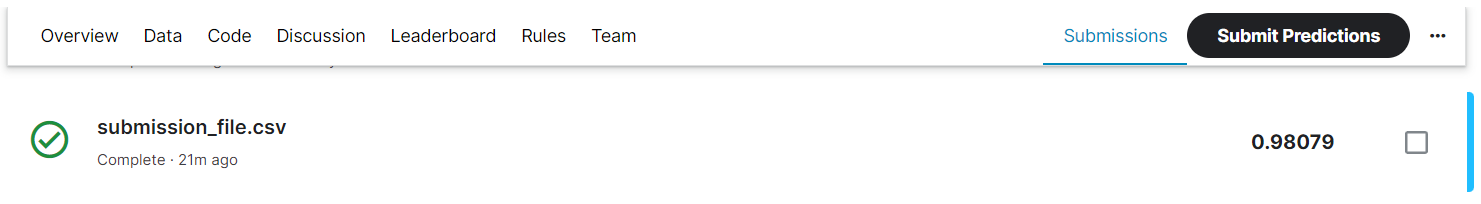